<a href="https://colab.research.google.com/github/SarahBarbosa/AluraDataChallenge_2/blob/main/S02_Feature_Engineering_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://imgur.com/QnT31vZ.png)

---

# Sobre o desafio

Na semana 02, vamos focar na construção e otimização de modelos de machine learning (ML) para lidar com a Taxa de Churn. Agora que terminamos a análise inicial dos dados na semana 01, é hora de usar algoritmos de ML para transformar nossos insights em ações eficazes.

## Configurando o ambiente

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Github/AluraDataChallenge_2')

## Carregando os dados da Semana 01

In [2]:
import pandas as pd

DIRETORIO_BASE = '/content/drive/MyDrive/Github/AluraDataChallenge_2/'
DIRETORIO_DADOS = DIRETORIO_BASE + 'Dados/'

dados_novexus = pd.read_csv(DIRETORIO_DADOS + 'dados_novexus.csv')
dados_ml = dados_novexus.copy()

In [3]:
dados_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [4]:
# Refazendo alguns passos da semana 01
import justdoit as jdi
tratamentos = jdi.Tratamentos(dados_ml)

tratamentos.string_to_float(colunas = 'account.Charges.Total')
dados_ml = tratamentos.remove_ausentes(colunas = 'Churn', string = False)
dados_ml = tratamentos.remove_colunas('customerID')

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Lidando com o desbalanceamento de dados da target</h1>
</div>

Durante a primeira semana do nosso projeto, uma observação veio à tona: nossos dados da target 'Churn' apresentam um desbalanceamento, conforme evidenciado abaixo:

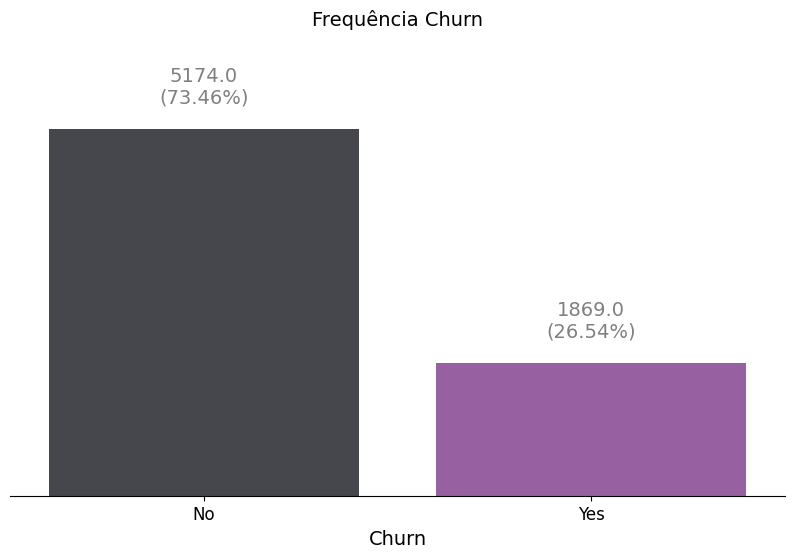

In [5]:
import justplotit as jpi
jpi.frequencia_churn(dados_ml)

O que esse balanceamento nos diz se quisermos prever quais clientes deixaram a empresa Novexus? Quando formos criar nosso modelo de Machine Learning, treinar e avaliar, vamos eventualmente perceber que o modelo terá um bom desempenho para prever corretamente que os clientes que saíram da empresa realmente saíram, mas ele vai ter um péssimo desempenho para identificar corretamente quais clientes saíram da empresa (recall baixo e, eventualmente, o f1-score será baixo também). Assim o modelo está estaria fazendo bom trabalho em identificar clientes que não irão sair da empresa, mas está falhando em identificar clientes que irão sair da empresa.

Para melhorar o desempenho do modelo, podemos pensar em duas alternativas: ou deixamos esses dados balanceados ou podemos adicionar mais features relevantes ao conjunto de dados de treinamento.


## Abordagem 1: Ignorar o desbalanceamento

> A primeira abordagem consiste em ignorar completamente o desbalanceamento e construir nosso modelo sem fazer ajustes específicos para corrigir. Se desenvolvermos um modelo sem considerar essa desproporcionalidade nos dados, o modelo será vítima do Paradoxo da Acurácia, em que os parâmetros do algoritmo não diferenciarão a classe minoritária das demais categorias, acreditando que estão agregando resultado devido à aparente alta acurácia.

## Abordagem 2: Oversamplig

> A segunda abordagem é utilizar a técnica [SMOTE](https://arxiv.org/pdf/1106.1813.pdf) (Synthetic Minority Over-sampling Technique). Essa técnica envolve a criação de informações sintéticas com base nas observações já existentes na classe minoritária. Esses dados "sintéticos" são gerados de forma a serem semelhantes aos dados reais, embora não sejam idênticos. Essa abordagem visa equilibrar a representação das classes, tornando o modelo mais capaz de identificar corretamente os casos da classe minoritária. Essa técnica no entanto pde introduzir viés nos dados ao gerar amostras sintéticas que estão próximas de exemplos existentes da classe minoritária. Isso pode levar a um melhor desempenho do modelo na classe minoritária, mas pode prejudicar o desempenho do modelo na classe majoritária.

**Observação:** Como essa técnica trabalha apenas com valores númericos e não foi projetada para lidar com features categóricas, vamos deixar para usar essa abordagem diretamente após o pipeline.



<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Encoding e Feature Engineering</h1>
</div>

Como vimos anteriormente, uma maneira de melhorar nosso modelo é adicionando novas features. Mas quais seriam elas?

*Observação*: deixamos em inglês pois as colunas originais não foram traduzidas na semana 01.

> Calculamos o número total de serviços recebidos por cada cliente com base em várias condições relacionadas aos serviços de internet. Isso nos dá uma visão geral do alcance dos serviços utilizados pelos clientes.

> Por fim, para determinar o custo por serviço, dividimos o valor mensal dos gastos pelo número total de serviços mais um (adicionando "+1" para evitar divisões por zero quando não há nenhum serviço contratado).

O processo de pipeline completo, além dessas novas features, inclui as seguintes etapas adicionais:

1. Utilização da codificação One-Hot que desenvolvemos na semana 01.
2. Eliminação das colunas duplicadas relacionadas aos serviços de internet e telefone que identificamos na semana 01.
3. Exclusão da coluna `account.Charges.Total`, uma vez que esta informação é duplicada e pode ser representada como `custume.Tenure * account.Charges.Montly`.
4. Normalização dos dados numéricos utilizando o Standard Scaler (padroniza as features, removendo a média e dimensionando para uma variação unitária).
5. Renomeação das colunas para melhor clareza e organização.

In [6]:
# Lista de colunas com valores 'Sim' ou 'Não'
colunas_sim_nao = ['Churn', 'customer.Partner', 'customer.Dependents',
                   'phone.PhoneService', 'account.PaperlessBilling']

# Lista de colunas com valores multiclasses
colunas_multiclasses = ['internet.InternetService', 'account.Contract',
                        'account.PaymentMethod']

# Lista de colunas com valores mistos
colunas_mistas = ['phone.MultipleLines', 'internet.OnlineSecurity',
                  'internet.OnlineBackup', 'internet.DeviceProtection',
                  'internet.TechSupport', 'internet.StreamingTV',
                  'internet.StreamingMovies']

In [7]:
dados_ml = jdi.pipeline_features(dados_ml, colunas_sim_nao, colunas_multiclasses, colunas_mistas)

In [8]:
# Abordagem 01
X_ignore = dados_ml.drop('Churn', axis = 1)   # Conjunto de features
y_ignore = dados_ml['Churn']                  # Conjunto da target Churn

# Abordagem 02
from imblearn.over_sampling import SMOTE
X_oversample, y_oversample = SMOTE(random_state = 42).fit_resample(X_ignore, y_ignore)

A partir deste ponto, nosso trabalho se ramificará nessas duas abordagens distintas. Ao final, identificaremos qual delas é a mais eficaz, juntamente com a escolha do modelo de classificação adequado. Também discutiremos as medidas que a empresa Novexus pode adotar para reduzir a taxa de Churn.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Construção do modelo</h1>
</div>

## Conjunto de treino e teste

In [9]:
from sklearn.model_selection import train_test_split

X_ab1_train, X_ab1_test, y_ab1_train, y_ab1_test = train_test_split(X_ignore, y_ignore, test_size=0.2, random_state = 42)
X_ab2_train, X_ab2_test, y_ab2_train, y_ab2_test = train_test_split(X_oversample, y_oversample, test_size=0.2, random_state = 42)

##  Usando K-fold Cross-Validation

Uma maneira de avaliar um modelo seria dividir o conjunto de treinamento em dois grupos: um menor para treinamento e outro para validação. Em seguida, o modelo seria treinado com base no conjunto de treinamento menor e avaliado com base no conjunto de validação. No entanto, uma abordagem muito mais eficaz é a utilização da **K-fold Cross-Validation**. Neste método, o conjunto de treinamento é dividido aleatoriamente em 3 (`cv = 3`) subconjuntos distintos (por exemplo), chamados "folds". Posteriormente, o modelo (ou conjunto de modelos) é treinado e avaliado 3 vezes, com um fold diferente sendo escolhido para avaliação a cada iteração, enquanto os outros 2 folds são utilizados para treinamento.

**Observação:** Utilizamos o **`StratifiedKFold`** também, que é um tipo específico de K-fold Cross-Validation, onde a distribuição de classe target é preservada em cada fold. Isso é particularmente útil ao lidar com conjuntos de dados desequilibrados (que é o nosso caso para a primeira abordagem). Isso garante que cada fold mantenha a mesma distribuição de classes do conjunto de dados original, o que pode resultar em uma avaliação mais robusta do modelo, especialmente quando se trabalha com classes desequilibradas.

In [10]:
%%capture
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
try:
  from catboost import CatBoostClassifier
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
random_state = 42
classificadores = [('Regressão Logística', LogisticRegression(random_state = random_state, max_iter=1000)),
                      ('K-Vizinhos Mais Próximos (KNN)', KNeighborsClassifier()),
                      ('Árvore de Decisão', DecisionTreeClassifier(random_state = random_state)),
                      ('Floresta Randômica', RandomForestClassifier(random_state = random_state)),
                      ('Gradient Boosting', GradientBoostingClassifier(random_state = random_state)),
                      ('AdaBoost', AdaBoostClassifier(random_state = random_state)),
                      ('Support Vector Machine', SVC(random_state = random_state)),
                      ('XGBoost', XGBClassifier(random_state = random_state)),
                      ('LightGBM', LGBMClassifier(random_state = random_state, verbose=0, force_row_wise=True)),
                      ('CatBoost', CatBoostClassifier(random_state = random_state))]

In [12]:
df_resultado_ab1, df_style_ab1 = jdi.cross_validation_models_set('default', X_ab1_train, y_ab1_train, classificadores)
df_style_ab1

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.844000,0.801000,0.651000,0.542000,0.592000
1,K-Vizinhos Mais Próximos (KNN),0.780000,0.759000,0.549000,0.526000,0.537000
2,Árvore de Decisão,0.659000,0.727000,0.487000,0.511000,0.498000
3,Floresta Randômica,0.821000,0.786000,0.625000,0.483000,0.545000
4,Gradient Boosting,0.845000,0.801000,0.660000,0.515000,0.579000
5,AdaBoost,0.842000,0.796000,0.642000,0.529000,0.580000
6,Support Vector Machine,0.798000,0.799000,0.663000,0.496000,0.567000
7,XGBoost,0.816000,0.778000,0.596000,0.511000,0.550000
8,LightGBM,0.830000,0.789000,0.626000,0.514000,0.564000
9,CatBoost,0.837000,0.794000,0.642000,0.508000,0.567000


In [13]:
df_resultado_ab2, df_style_ab2 = jdi.cross_validation_models_set('oversampling', X_ab2_train, y_ab2_train, classificadores)
df_style_ab2

,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.900000,0.816000,0.803000,0.836000,0.819000
1,K-Vizinhos Mais Próximos (KNN),0.863000,0.793000,0.746000,0.888000,0.811000
2,Árvore de Decisão,0.762000,0.761000,0.761000,0.759000,0.760000
3,Floresta Randômica,0.909000,0.827000,0.809000,0.857000,0.832000
4,Gradient Boosting,0.887000,0.807000,0.781000,0.853000,0.815000
5,AdaBoost,0.871000,0.794000,0.766000,0.845000,0.803000
6,Support Vector Machine,0.889000,0.811000,0.792000,0.842000,0.816000
7,XGBoost,0.916000,0.832000,0.818000,0.852000,0.835000
8,LightGBM,0.914000,0.834000,0.811000,0.871000,0.840000
9,CatBoost,0.916000,0.833000,0.813000,0.866000,0.838000


### Análise preliminar

Após o treinamento de 10 modelos, percebemos que Regressão Logística (para a primeira abordagem) e LightGBM (para a segunda abordagem) apresentam o maior desempenho com F1-score.

Escolheremos mais três modelos com melhor desempelho nessa métrica para cada abordagem e faremos um hyperparameter tuning usando Grid Search.

In [14]:
print('## Abordagem 01')
df_resultado_ab1.sort_values('F1-Score', ascending = False).head(4)

## Abordagem 01


,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
0,Regressão Logística,0.844,0.801,0.651,0.542,0.592
5,AdaBoost,0.842,0.796,0.642,0.529,0.580
4,Gradient Boosting,0.845,0.801,0.660,0.515,0.579
6,Support Vector Machine,0.798,0.799,0.663,0.496,0.567


In [15]:
print('## Abordagem 02')
df_resultado_ab2.sort_values('F1-Score', ascending = False).head(4)

## Abordagem 02


,Modelo,ROC-AUC,Accuracy,Precision,Recall,F1-Score
8,LightGBM,0.914,0.834,0.811,0.871,0.840
9,CatBoost,0.916,0.833,0.813,0.866,0.838
7,XGBoost,0.916,0.832,0.818,0.852,0.835
3,Floresta Randômica,0.909,0.827,0.809,0.857,0.832


## Hyperparameter tuning usando Grid Search

Vamos configurar a grade de parâmetros para cada modelo:

In [16]:
param_grid_logistic = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter':[1000]
    }

param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
    }

param_grid_gradient_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
    }

catboost_param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10]
    }

xgboost_param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
    }

random_forest_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
    }

lightgbm_param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.1]
    }

svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
                  }

In [17]:
random_state = 42
classificadores_ab1 = [('Regressão Logística', LogisticRegression(random_state = random_state, max_iter=1000), param_grid_logistic),
                       ('Gradient Boosting', GradientBoostingClassifier(random_state = random_state), param_grid_gradient_boosting),
                       ('AdaBoost', AdaBoostClassifier(random_state = random_state), param_grid_adaboost),
                       ('Support Vector Machine', SVC(random_state = random_state), svm_param_grid)
                       ]

classificadores_ab2 = [('CatBoost', CatBoostClassifier(random_state = random_state), catboost_param_grid),
                       ('Floresta Randômica', RandomForestClassifier(random_state = random_state), random_forest_param_grid),
                       ('LightGBM', LGBMClassifier(random_state = random_state, verbose=0, force_row_wise=True), lightgbm_param_grid),
                       ('XGBoost', XGBClassifier(random_state = random_state), xgboost_param_grid)]

In [18]:
from sklearn.model_selection import GridSearchCV

grid_search_resultado_ab1 = jdi.hyperparameter_optimization(X_ab1_train, y_ab1_train, classificadores_ab1)

# Melhores parâmetros para Regressão Logística: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
# Melhores parâmetros para Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
# Melhores parâmetros para AdaBoost: {'learning_rate': 0.2, 'n_estimators': 200}
# Melhores parâmetros para Support Vector Machine: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [19]:
grid_search_resultado_ab2 = jdi.hyperparameter_optimization(X_ab2_train, y_ab2_train, classificadores_ab2)

# Melhores parâmetros para CatBoost: {'depth': 8, 'iterations': 150, 'learning_rate': 0.2}
# Melhores parâmetros para Floresta Randômica: {'max_depth': 15, 'n_estimators': 150}
# Melhores parâmetros para LightGBM: {'learning_rate': 0.1, 'n_estimators': 300}
# Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [20]:
print('## Abordagem 01')
grid_search_resultado_ab1.sort_values('F1 Macro Score', ascending = False)

## Abordagem 01


,Modelo,F1 Macro Score,Accuracy
2,AdaBoost,0.734338,0.805644
0,Regressão Logística,0.733871,0.803337
3,Support Vector Machine,0.729456,0.801207
1,Gradient Boosting,0.724567,0.798367


In [21]:
print('## Abordagem 02')
grid_search_resultado_ab2.sort_values('F1 Macro Score', ascending = False)

## Abordagem 02


,Modelo,F1 Macro Score,Accuracy
0,CatBoost,0.842024,0.842112
2,LightGBM,0.838781,0.838851
1,Floresta Randômica,0.831052,0.831360
3,XGBoost,0.829446,0.829670


Com base nos resultados de acurácia e pontuação F1, o modelo que se destaca entre as quatro opções é a **AdaBoost** (superando um pouco a regressão logística no F1-score) para a primeira abordagem, enquanto o **CatBoost** ainda domina na abordagem 02. Vamos analisar mais detalhadamente:

- **Acurácia**: AdaBoost atingiu uma taxa de acurácia de 80,56%, o que significa que classificou corretamente cerca de 80,56% das instâncias no conjunto de dados. Geralmente, procuramos obter uma alta acurácia, pois isso reflete o quão precisamente o modelo está prevendo a variável-alvo. Na segunda abordagem, a acurácia é mais de 4% maior em comparação com a primeira.

- **Pontuação F1**: AdaBoost alcançou uma pontuação F1 de 73,43%. Esta métrica é uma medida que leva em consideração tanto a precisão quanto a recall do modelo. Ela fornece uma avaliação equilibrada da capacidade do modelo em identificar corretamente instâncias positivas (precisão) e capturar todas as instâncias positivas (recall). Uma pontuação F1 mais alta indica um melhor desempenho global em termos de precisão e recall. Na abordagem 02, é 11% superior.

Com base nesses resultados, podemos sugerir os seguintes conjuntos de hiperparâmetros recomendados:

> **AdaBoost:** `{'learning_rate': 0.2, 'n_estimators': 200}`

> **CatBoost:** `{'depth': 8, 'iterations': 150, 'learning_rate': 0.2}`.

## AdaBoost e Catboost como melhores modelos

In [22]:
random_state = 42
adaboost = AdaBoostClassifier(learning_rate = 0.2, n_estimators = 200,random_state = random_state)
catboost = CatBoostClassifier(depth = 8, iterations = 150, learning_rate = 0.2, random_state = random_state)

adaboost.fit(X_ab1_train, y_ab1_train)
catboost.fit(X_ab2_train, y_ab2_train)

### Visualizando os atributos mais importantes

In [23]:
importancia_adam = pd.DataFrame({'Feature': X_ab1_train.columns,
                                 'Importância': adaboost.feature_importances_}).sort_values(by='Importância',
                                                                                            ascending=False)
importancia_cat = pd.DataFrame({'Feature': X_ab2_train.columns,
                                'Importância': catboost.get_feature_importance()}).sort_values(by='Importância',
                                                                                               ascending=False)

Para o **AdaBoostClassifier** as importâncias da feature são baseadas em impurezas. Quanto mais alto, mais importante é a feature. A importância de uma feature é calculada como a redução total (normalizada) do critério trazido por esse recurso. Também é conhecida como importância de Gini.

No CatBoost, a importância das features no CatBoost sobre o quanto cada feature contribui para as previsões do modelo. Essas pontuações são calculadas com base nos mecanismos internos do algoritmo CatBoost, que inclui aumento de gradiente com suporte a feature categóricos.


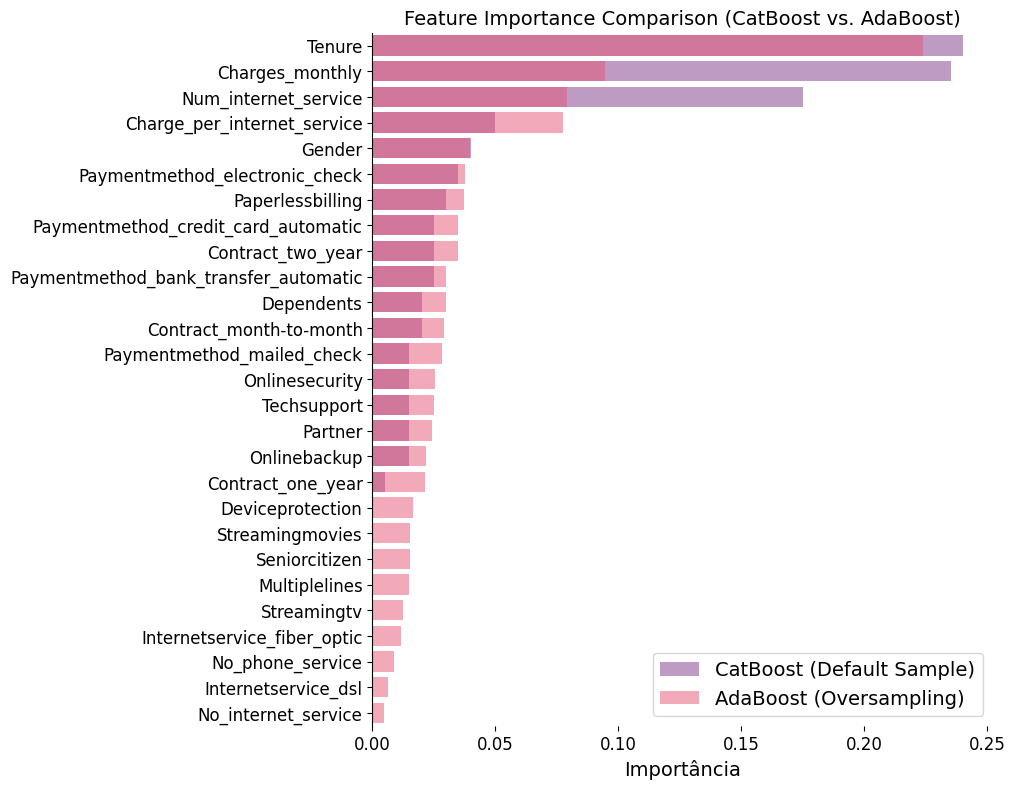

In [24]:
jpi.feature_importance_comparacao(importancia_adam, importancia_cat, 'CatBoost', 'AdaBoost', resize = True)

O gráfico acima representa a importância relativa ou a força de cada feature em cada modelo preditivo.

- Tenure (Tempo de Permanência): Esta feature mais forte nos dois modelos,o que faz sentido, se lembrarmos da análise da semana 01, vimos que um período de permanência mais longo está associado a uma menor probabilidade de cancelamento.

- Charges Monthly (Mensalidades): O coeficiente desta feature também é forte, o que está de acordo com nossas análises da semana 01 também, onde cobranças mais altas podem estar associadas a uma maior probabilidade de cancelamento. Isso também faz jus ao número de serviços de internet e o preço por cada um desses serviços.


<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Avaliação dos modelos</h1>
</div>

## Previsões dos Modelos

In [25]:
adaboost_predictions = adaboost.predict(X_ab1_test)
catboost_predictions = catboost.predict(X_ab2_test)

## Comparação dos valores reais com os valores previstos

In [26]:
from sklearn.metrics import classification_report

adaboost_report = classification_report(y_ab1_test, adaboost_predictions)
catboost_report = classification_report(y_ab2_test, catboost_predictions)


print("Relatório de Classificação para AdaBoost (Default Sampling):")
print(adaboost_report)

print("\nRelatório de Classificação para CatBoost (Oversampling):")
print(catboost_report)

Relatório de Classificação para AdaBoost (Default Sampling):
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1036
           1       0.66      0.52      0.58       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409


Relatório de Classificação para CatBoost (Oversampling):
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1027
           1       0.85      0.86      0.85      1043

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



Aqui estão algumas interpretações significativas das métricas:

- **Precision**: A precisão da classe 0 (Não) é notavelmente alta em ambos os modelos, com 84% no AdaBoost e 86% no CatBoost. Isso indica que quando os modelos prevêem a classe Não, eles estão acertando a maioria das vezes. No entanto, a precisão da classe 1 (Sim) varia consideravelmente, com 66% no AdaBoost e impressionantes 85% no CatBoost. Isso sugere que o CatBoost é particularmente eficaz em prever a classe Sim.

- **Recall**: O recall da classe 0 é alto no AdaBoost (90%) e no CatBoost (84%). Isso significa que ambos os modelos são capazes de identificar corretamente a maioria das instâncias da classe Não. No entanto, o recall da classe 1 é notavelmente baixo no AdaBoost (52%) e alto no CatBoost (86%). O CatBoost supera o AdaBoost em capturar as instâncias da classe Sim, tornando-se uma escolha mais confiável nesse aspecto.

- **F1-Score**: O F1-Score, uma métrica que equilibra precisão e recall, destaca que o AdaBoost alcança um F1-Score mais baixo para a classe 1 (58%), enquanto o CatBoost atinge um F1-Score mais consistente e elevado tanto para a classe 0 (85%) quanto para a classe 1 (85%). Isso indica que o CatBoost oferece um equilíbrio melhor entre precisão e recall para ambas as classes.

- **Accuracy**: A acurácia geral é uma medida importante, e o CatBoost supera o AdaBoost com uma acurácia de 85% em comparação com 80%. Isso significa que o CatBoost prevê corretamente a classe da maioria das instâncias em seu conjunto de dados.

- **Conclusão**: Em resumo, ambos os modelos têm bom desempenho na previsão da classe Não (0), com alta precisão e recall. No entanto, o CatBoost destaca-se na previsão da classe Sim (1), oferecendo maior precisão, recall e F1-Score. Portanto, se a previsão da classe Sim é de alta importância, o CatBoost é a escolha preferível, especialmente quando se utiliza oversampling para melhorar o desempenho.

## Visualizando a matriz de confusão para o CatBoost

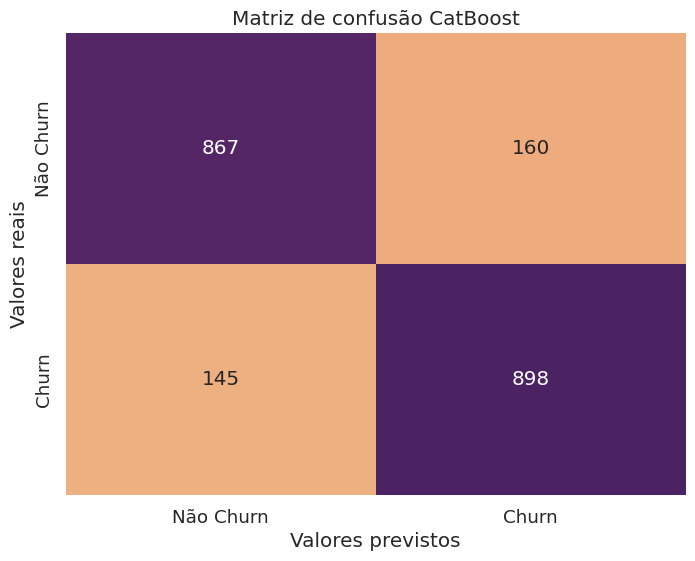

In [27]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_ab2_test, catboost_predictions)
jpi.confusion_matrix(conf_matrix, 'CatBoost')

## Visualizar decisões do modelo escolhido

O `shap.decision_plot` é uma função da biblioteca SHAP (SHapley Additive exPlanations) que permite visualizar como as decisões de um modelo ML são influenciadas pelas diferentes features de entrada. Esta função é especialmente útil para entender como o modelo toma decisões, destacando as features mais importantes em diferentes partes da tomada de decisão.


In [28]:
%%capture
try:
  import shap
except ModuleNotFoundError:
  !pip install shap
  import shap

In [29]:
explainer = shap.TreeExplainer(catboost)
shap_values_cat_test = explainer.shap_values(X_ab2_test)
shap_values_cat_train = explainer.shap_values(X_ab2_train)

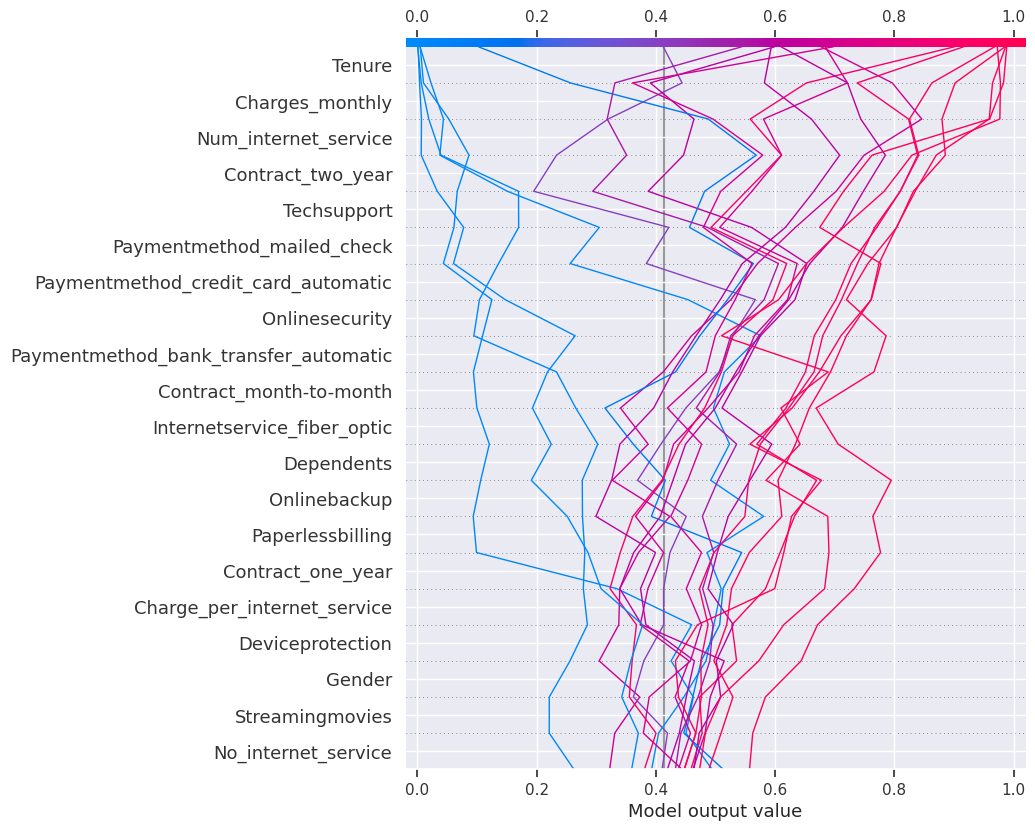

In [30]:
ax = shap.decision_plot(explainer.expected_value, shap_values_cat_test[:20], X_ab2_test.iloc[:20], link= "logit")

Aqui o eixo x representa a saída do modelo. Neste caso, as unidades são probabilidades logarítmicas. O eixo y lista as features do modelo. Por padrão, as features são ordenadas por importância decrescente. A previsão de cada observação é representada por uma linha colorida. No topo do gráfico, cada linha atinge o eixo x no valor previsto da sua observação correspondente. Este valor determina a cor da linha em um espectro.


### Cliente 15 e 35

Vamos dar olhada nesses dois clientes mais de perto

In [31]:
X_ab2_test.iloc[15]

Gender                                   0.000000
Seniorcitizen                            0.000000
Partner                                  0.000000
Dependents                               0.000000
Tenure                                  -0.870241
Multiplelines                            0.000000
Onlinesecurity                           0.000000
Onlinebackup                             0.000000
Deviceprotection                         1.000000
Techsupport                              0.000000
Streamingtv                              0.000000
Streamingmovies                          0.000000
Paperlessbilling                         0.000000
Charges_monthly                          0.270484
Internetservice_dsl                      0.000000
Internetservice_fiber_optic              1.000000
Contract_month-to-month                  1.000000
Contract_one_year                        0.000000
Contract_two_year                        0.000000
Paymentmethod_bank_transfer_automatic    0.000000


Este cliente é:
- Homem
- Jovem/Adulto
- Não possui dependentes nem parceiros
- Não possui múltiplas linhas telefônicas
- Não possui serviços como segurança e backup mas possui proteção
- Sem suporte técnico e nem serviços de streamings
- Possui internet fibra ótica e um contrato mês-a-mês.
- Usa cheque eletrônico para fazer os pagamentos.

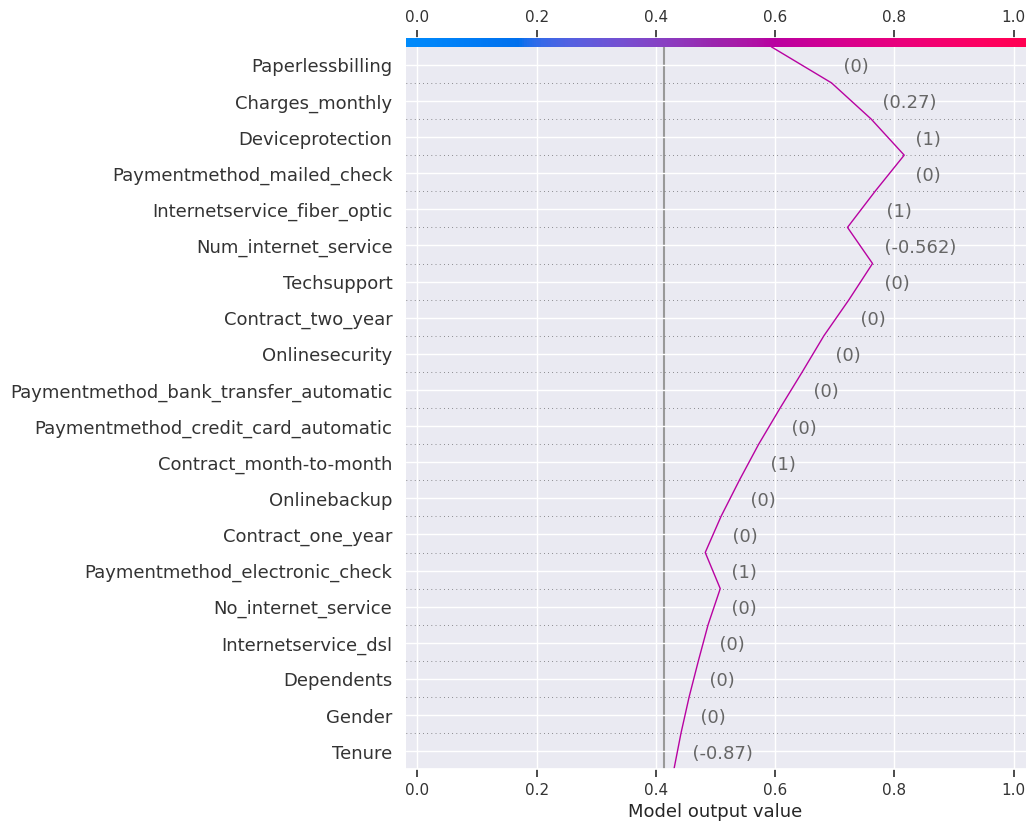

In [32]:
ax = shap.decision_plot(explainer.expected_value, shap_values_cat_test[15], X_ab2_test.iloc[[15]], link= "logit")

A partir do gráfico de decisão, verifica-se que ter assinatura adicional de proteção no dispositivo vom a empresa tem o efeito mais significativo no aumento da probabilidade de decisão de churn neste modelo para este cliente específico.

In [33]:
X_ab2_test.iloc[35]

Gender                                   1.000000
Seniorcitizen                            0.000000
Partner                                  1.000000
Dependents                               0.000000
Tenure                                  -0.340876
Multiplelines                            0.000000
Onlinesecurity                           0.000000
Onlinebackup                             0.000000
Deviceprotection                         0.000000
Techsupport                              0.000000
Streamingtv                              0.000000
Streamingmovies                          0.000000
Paperlessbilling                         0.000000
Charges_monthly                         -1.474403
Internetservice_dsl                      0.000000
Internetservice_fiber_optic              0.000000
Contract_month-to-month                  0.000000
Contract_one_year                        1.000000
Contract_two_year                        0.000000
Paymentmethod_bank_transfer_automatic    0.000000


Este cliente é:
- Mulher
- Jovem/Adulto
- Não possui parceiros mas não dependentes
- Não possui múltiplas linhas telefônicas
- Não possui nenhum serviços de internet
- Sem suporte técnico e nem serviços de streamings
- Possui um contrato de 1 ano
- Usa cartão de crédito automático como pagamentos
- Só usa serviços de telefone

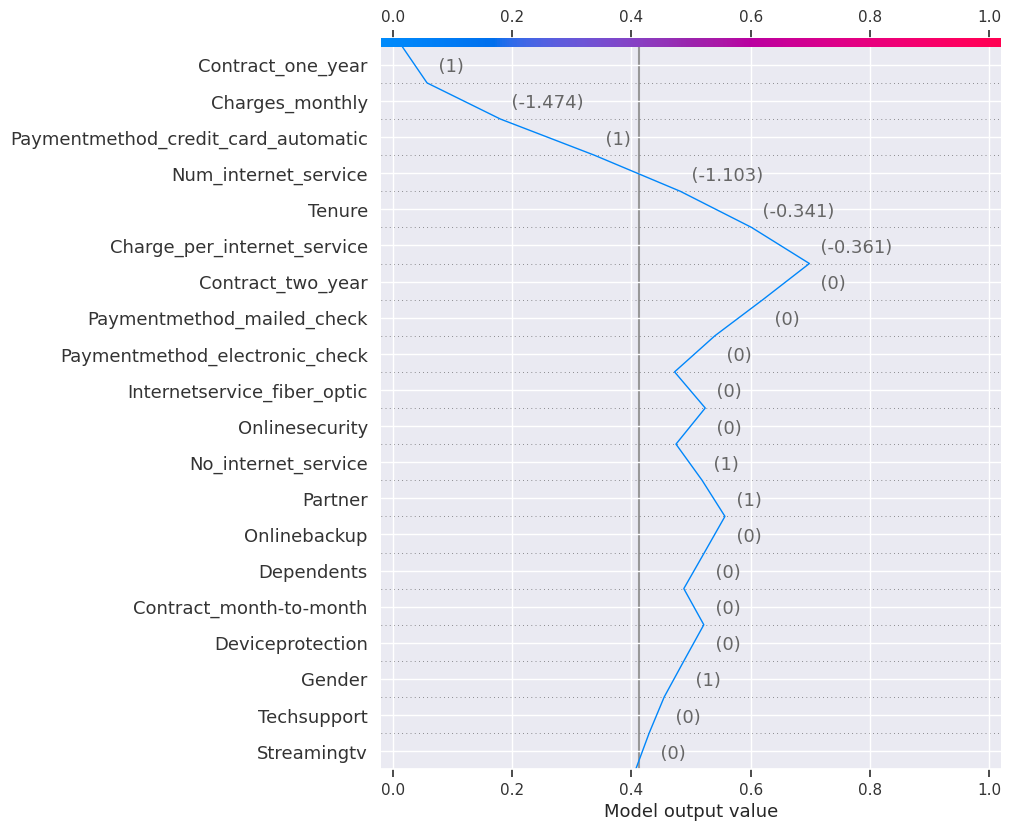

In [34]:
ax = shap.decision_plot(explainer.expected_value, shap_values_cat_test[35], X_ab2_test.iloc[[35]], link= "logit")

A partir do gráfico de decisão, verifica-se que ter um contrato de um ano com a empresa tem o efeito mais significativo na probabilidade de decisão de não desligamento neste modelo para este cliente específico.

<div style="background-color: #171821; color: white; padding: 10px; text-align: center; font-size: 20px;">
    <h1>Salvando o melhor modelo: CatBoost</h1>
</div>

In [35]:
import joblib

best_model = DIRETORIO_BASE + 'modelo_catboost.pkl'
joblib.dump(catboost, best_model)

['/content/drive/MyDrive/Github/AluraDataChallenge_2/modelo_catboost.pkl']